# Setup
## Downloading Packages

In [126]:
# To install the kaggle package in the notebook WARNING Installs System wide
# Download API key from Kaggle from Accounts - Create New Api Token
# Move the downloaded kaggle.json to ~/.kaggle/

# import sys
# !{sys.executable} -m pip install kaggle

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

## Downloading Instacart data using the Kaggle API
Unzipping and Cleaning CSV zip files

In [2]:
# Downloading CSV data, unzipping and moving to csv_src folder

# After isntalling the kaggle module and setting kaggle.json api keys
# Download the dataset from the Kaggle
!kaggle competitions download -c instacart-market-basket-analysis

# Custom shell script to unzip all files, remove zips and move csv into csv_src
# The unzip_rm.sh script should be in the same directory as the python notebook file
!chmod u+x unzip_rm.sh
!./unzip_rm.sh

  0%|                                                 | 0.00/804 [00:00<?, ?B/s]
100%|███████████████████████████████████████████| 804/804 [00:00<00:00, 488kB/s]
  0%|                                               | 0.00/1.87k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 1.87k/1.87k [00:00<00:00, 1.87MB/s]
100%|██████████████████████████████████████| 6.90M/6.90M [00:01<00:00, 6.22MB/s]

100%|█████████████████████████████████████████| 795k/795k [00:01<00:00, 689kB/s]

 99%|█████████████████████████████████████▋| 31.0M/31.3M [00:53<00:00, 1.94MB/s]
100%|███████████████████████████████████████| 31.3M/31.3M [00:53<00:00, 612kB/s]
100%|███████████████████████████████████████▉| 157M/157M [03:17<00:00, 5.49MB/s]
100%|█████████████████████████████████████████| 157M/157M [03:17<00:00, 835kB/s]
  0%|                                                | 0.00/220k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 220k/220k [00:00<00:00, 10.7MB/s]
Archive:  aisles.csv.zip
 

## Loading CSV files into DataFrames

In [97]:
# Reading all the datasets from the csv_src folder
csv_folder = 'csv_src/'
aisle = pd.read_csv( csv_folder+'aisles.csv')
orders = pd.read_csv(csv_folder+'orders.csv')
products = pd.read_csv(csv_folder+'products.csv')
departments = pd.read_csv( csv_folder+'departments.csv')
order_prior = pd.read_csv(csv_folder+'order_products__prior.csv') 
order_train = pd.read_csv(csv_folder+'order_products__train.csv')

## Setting the ids as index
#### Setting NAs to zeros

In [98]:
# Setting the correct indexes for the data sets

orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

In [116]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [100]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [101]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [117]:
aisle.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [120]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [121]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Joining the products dframe with departments and aisle dframes

In [110]:
# Doing left joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_comb = products.reset_index().set_index('department_id').join(departments)
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle)

In [111]:
# Setting the index to 'product_id' and sorting it
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)

In [114]:
product_comb.head()

,aisle_id,department_id,product_name,department,aisle
product_id,,,,,
1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,104,13,All-Seasons Salt,pantry,spices seasonings
3,94,7,Robust Golden Unsweetened Oolong Tea,beverages,tea
4,38,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
5,5,13,Green Chile Anytime Sauce,pantry,marinades meat preparation


In [141]:
orders

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0
3367565,1,prior,6,2,7,19.0
550135,1,prior,7,1,9,20.0
3108588,1,prior,8,1,14,14.0
2295261,1,prior,9,1,16,0.0


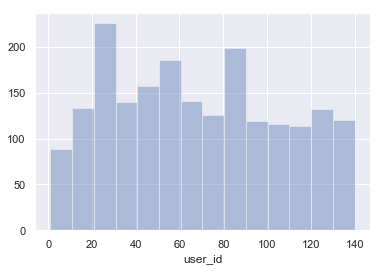

In [186]:
sns.set(color_codes=True)
xd = orders.iloc[0:2000,0] # order_id
sns.distplot(xd, kde=False)

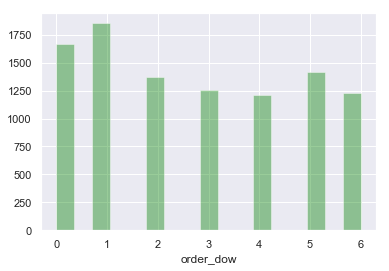

In [183]:
x = orders.iloc[0:10000,3]
sns.distplot(x, kde=False, color="green")

In [ ]:
x = orders.iloc[0:10000,4]
sns.distplot(x, kde=False, color="green")

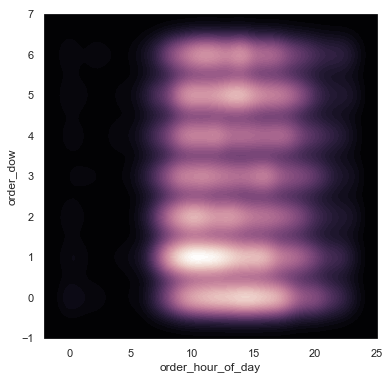

In [163]:
smallset = orders[0:10000]

f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(smallset.order_hour_of_day, smallset.order_dow, cmap=cmap, n_levels=60, shade=True);

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0
3367565,1,prior,6,2,7,19.0
550135,1,prior,7,1,9,20.0
3108588,1,prior,8,1,14,14.0
2295261,1,prior,9,1,16,0.0


In [145]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0
